# LeNet-5

Perhaps the first widely known and successful application of convolutional neural networks was **LeNet-5**, described by Yann LeCun, et al. in their 1998 paper titled [Gradient-Based Learning Applied to Document Recognition](https://ieeexplore.ieee.org/document/726791). The system was developed for use in a handwritten character recognition problem and demonstrated on the **MNIST standard dataset**, achieving approximately 99.2% classification accuracy (or a 0.8% error rate). The network was then described as the central technique in a broader system referred to as **Graph Transformer Networks**.

It is a long paper, and perhaps the best part to focus on is Section II. B. that describes the LeNet-5 architecture. In that section, the paper describes the **network as having seven layers** with input **grayscale images** having the shape **32 x 32**, the size of images in the **MNIST dataset**. 

> The model proposes a pattern of a convolutional layer followed by an average pooling layer, referred to as a **subsampling layer**. 

This pattern is repeated two and a half times before the output feature maps are flattened and fed to some fully connected layers for interpretation and a final prediction. A picture of the network architecture is provided in the paper and reproduced below.

<img width="800" src="https://drive.google.com/uc?export=view&id=1nqbLzHfqorX80I8upHMWINwPNfrmLW-V"/>

The pattern of blocks of convolutional layers and pooling layers (referred to as **subsampling**) grouped and repeated **remains a typical pattern in designing and using convolutional neural networks today, more than twenty years later**. Interestingly, the architecture uses a small number of filters with a modest size as the first hidden layer, specifically 6 filters, each with 5x5 pixels. After pooling, another convolutional layer has many more filters, again with the same size, precisely 16 filters with 5x5 pixels, again followed by pooling. In the repetition of these two blocks of convolution and pooling layers, the trend increases the number of filters.

Compared to modern applications, the number of filters is also small, but **the trend of increasing the number of filters with the depth of the network also remains a common pattern in modern usage of the technique.** The flattening of the feature maps and interpretation and classification of the extracted features by fully connected layers also remains a common pattern today. 

> In modern terminology, the **final section of the architecture** is often referred to as the **classifier**, whereas the **convolutional and pooling layers** earlier in the model are referred to as the **feature extractor**.

We can summarize the key aspects of the architecture relevant in modern models as follows:

- Fixed-sized input images.
- Group convolutional and pooling layers into blocks.
- Repetition of convolutional-pooling blocks in the architecture.
- Increase in the number of filters with the depth of the network.
- Distinct feature extraction and classifier parts of the architecture.

## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [ ]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 166 kB 61.0 MB/s 
     |████████████████████████████████| 182 kB 64.0 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 166 kB 68.5 MB/s 
     |████████████████████████████████| 162 kB 75.9 MB/s 
     |████████████████████████████████| 162 kB 70.2 MB/s 
     |████████████████████████████████| 158 kB 60.7 MB/s 
     |████████████████████████████████| 157 kB 50.5 MB/s 
     |████████████████████████████████| 157 kB 50.1 MB/s 
     |████████████████████████████████| 157 kB 69.6 MB/s 
     |████████████████████████████████| 157 kB 68.8 MB/s 
     |████████████████████████████████| 157 kB 72.9 MB/s 
     |████████████████████████████████| 157 kB 72.2 MB/s 
     |████████████████████████████████| 157 kB 50.4 MB/s 
     |████████████████████████████████| 156 kB 68.5 MB/s 


In [ ]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 5.1 MB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
     |████████████████████████████████| 66 kB 5.2 MB/s 


### Import Packages

In [ ]:
# import the necessary packages
import logging
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Step 02: Implementing LeNet-5


<img width="800" src="https://drive.google.com/uc?export=view&id=1RF_HWPSImajab-i1ayFeEOoFON0Ky-28"/>

Source code based on **Rosebrock, Adrian. Deep Learning For Computer vision with Python, 2019** [link](https://pyimagesearch.com/deep-learning-computer-vision-python-book/)

In [9]:
from pickle import FALSE
class LeNet:
  ''' 
  # create LeNet-5 model
  #
  # it is composed of the 8 layers (5 layers considering FC as one layer) 
  # such as:
  #      - 2 convolutional layers
  #      - 2 subsampling (avg pooling) layers
  #      - 1 flatten layer
  #      - 2 fully connected layers
  #      - 1 output layer with 10 outputs
  '''
  @staticmethod
  def build(width, height, depth, classes, dropout = 0.0, typeActivation='tanh',isBatchNormalization = False):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(8, (5,5), strides=1, padding='same',
                     activation=typeActivation, input_shape=(28,28,1), )) #C1
    model.add(AveragePooling2D()) #S2
  
    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation='tanh')) #C3

    if isBatchNormalization: 
        model.add(BatchNormalization())

    model.add(AveragePooling2D()) #S4

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation='tanh')) #C5
    if dropout > 0.0:
      model.add(Dropout(dropout))
    #model.add(Dense(84, activation='tanh')) #F6

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [11]:
# create a model object
model = LeNet.build(28,28,1,10,dropout = 0.0, typeActivation='tanh',isBatchNormalization = True)

# summarize layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 8)         208       
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 8)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        3216      
                                                                 
 batch_normalization (BatchN  (None, 10, 10, 16)       64        
 ormalization)                                                   
                                                                 
 average_pooling2d_3 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                      

## Step 03:Hyperparameter

In [23]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "lenet-5"
}

hyperp = {
    'typeActivation':{
        'values':['tanh','relu']
    },
    'dropout':{
        'values': [0.0,0.1, 0.25]
    },
    'isBatchNormalization': {
        'values':[True,False] 
    },
  
}
sweep_config = {
    'method': 'grid',
    'metric':{
        'name': 'best_loss',
        'goal': 'minimize'
    },
    'parameters': hyperp
}
sweep_id = wandb.sweep(sweep_config, entity="pablosanttana", project=args["project_name"])

Create sweep with ID: 06xamqnj
Sweep URL: https://wandb.ai/pablosanttana/lenet-5/sweeps/06xamqnj


In [24]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a second)
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

10-11-2022 00:56:25 [INFO] accessing MNIST...
10-11-2022 00:56:25 Train x: (60000, 28, 28)
10-11-2022 00:56:25 Train y: (60000,)
10-11-2022 00:56:25 Test x: (10000, 28, 28)
10-11-2022 00:56:25 Test y: (10000,)


In [25]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
	test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
	test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [26]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

10-11-2022 00:56:29 Train x: (60000, 28, 28, 1)
10-11-2022 00:56:29 Train y: (60000,)
10-11-2022 00:56:29 Test x: (10000, 28, 28, 1)
10-11-2022 00:56:29 Test y: (10000,)


In [27]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

### Training 

In [28]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
def training():
  run = wandb.init(project="lenet-5", entity="pablosanttana",job_type="Train")
  tracker = EmissionsTracker(log_level="critical")
  tracker.start()

  # initialize the optimizer and model
  logger.info("[INFO] compiling model...")
  opt = Adam(learning_rate=0.01)
  model = LeNet.build(
      width=28, 
      height=28, 
      depth=1, 
      classes=10,
      dropout = wandb.config.dropout, 
      typeActivation=wandb.config.typeActivation,
      isBatchNormalization =wandb.config.isBatchNormalization
      )
  
  model.compile(loss="categorical_crossentropy", optimizer=opt,
                metrics=["accuracy"])

  # train the network
  logger.info("[INFO] training network...")
  history = model.fit(train_x, train_y,
                validation_data=(test_x, test_y),
                batch_size=32,
                epochs=20, 
                verbose=0,
                callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                    compute_flops=True)])

  # get co2 emissions from tracker
  # "CO2 emission (in Kg)"
  emissions = tracker.stop()
  predictions = model.predict(test_x, batch_size=32)
  print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=[str(i) for i in lb.classes_]))
  fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
  ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

  ax.set_xlabel("True Label")
  ax.set_ylabel("Predicted Label")
  ax.grid(False)
  logger.info("Uploading figures")

  run.log(
      {
          "confusion_matrix": wandb.Image(fig_confusion_matrix),
          # "other_figure": wandb.Image(other_fig)
      }
  )
    # Evaluation Metrics
  logger.info("Validation Evaluation metrics")
  fbeta = fbeta_score(test_y.argmax(axis=1), 
                      predictions.argmax(axis=1), 
                      beta=1, zero_division=1,average='weighted')
  precision = precision_score(test_y.argmax(axis=1),
                              predictions.argmax(axis=1),
                              zero_division=1,average='weighted')
  recall = recall_score(test_y.argmax(axis=1),
                        predictions.argmax(axis=1),
                        zero_division=1,average='weighted')
  acc = accuracy_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1))

  logger.info("Validation Accuracy: {}".format(acc))
  logger.info("Validation Precision: {}".format(precision))
  logger.info("Validation Recall: {}".format(recall))
  logger.info("Validation F1: {}".format(fbeta))

  run.summary["Acc"] = acc
  run.summary["Precision"] = precision
  run.summary["Recall"] = recall
  run.summary["F1"] = fbeta
  # number of parameters
  run.summary["Count_Params"] = model.count_params()
  # energy unit is kWh
  run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
  run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
  run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
  run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
  # kg
  run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions


In [29]:
!nvidia-smi

Thu Nov 10 00:56:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |   2934MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

wandb: Agent Starting Run: cpjf5bkp with config:
wandb: 	dropout: 0
wandb: 	isBatchNormalization: True
wandb: 	typeActivation: tanh
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 00:56:53 [INFO] compiling model...
10-11-2022 00:56:53 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


10-11-2022 00:58:54 Uploading figures


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.98      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.96      0.98      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.97       958
           7       0.98      0.95      0.97      1028
           8       0.98      0.92      0.95       974
           9       0.95      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



10-11-2022 00:58:54 Validation Evaluation metrics
10-11-2022 00:58:54 Validation Accuracy: 0.9681
10-11-2022 00:58:54 Validation Precision: 0.9683400069140833
10-11-2022 00:58:54 Validation Recall: 0.9681
10-11-2022 00:58:54 Validation F1: 0.9680514160749106


accuracy,▁▇█▇▇▆▇▇▇▆▇█▆▆▇▇▃▃▄▆
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▃▃▃▁▃▂▄▃▁▅▄▃▃█▇▆▄
val_accuracy,▆▇█▆▃▆▇▆▄▁▆█▅▆▇▃▅▂▅▇
val_loss,▂▁▁▃▅▂▃▃▅█▃▁▄▃▂▆▃▆▃▂
Acc,0.9681
CO2_Emissions,0.00079
Count_Params,52818
Energy_CPU,0.00142
Energy_Consumed,0.00276
Energy_GPU,0.00118


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7dayumup with config:
wandb: 	dropout: 0
wandb: 	isBatchNormalization: True
wandb: 	typeActivation: relu
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 00:59:16 [INFO] compiling model...
10-11-2022 00:59:16 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


10-11-2022 01:01:18 Uploading figures


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.97      0.98      1135
           2       0.96      0.98      0.97      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.91      0.95       982
           5       0.98      0.97      0.98       892
           6       0.96      0.98      0.97       958
           7       0.95      0.98      0.97      1028
           8       0.96      0.97      0.96       974
           9       0.94      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



10-11-2022 01:01:18 Validation Evaluation metrics
10-11-2022 01:01:18 Validation Accuracy: 0.9683
10-11-2022 01:01:18 Validation Precision: 0.9686228328308227
10-11-2022 01:01:18 Validation Recall: 0.9683
10-11-2022 01:01:18 Validation F1: 0.9682538792858398


accuracy,▁█▇██▆▆▆▅▆▆▅▄▁▅▅▅▅▅▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▇▁▂▂▂▄▄▄▄▃▄▅▅█▅▄▅▄▅▅
val_accuracy,▅▁▆▇█▅▅▅▆▆▅▅▆▅▅▅▇▅█▇
val_loss,▅█▂▂▁▄▃▃▃▄▄▄▂▃▄▃▂▅▁▂
Acc,0.9683
CO2_Emissions,0.00079
Count_Params,52818
Energy_CPU,0.00142
Energy_Consumed,0.00278
Energy_GPU,0.00119


wandb: Agent Starting Run: u9k4cvjr with config:
wandb: 	dropout: 0
wandb: 	isBatchNormalization: False
wandb: 	typeActivation: tanh
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 01:01:29 [INFO] compiling model...
10-11-2022 01:01:29 [INFO] training network...


313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.95      0.99      0.97      1010
           4       0.99      0.97      0.98       982
           5       0.97      0.96      0.97       892
           6       0.97      0.98      0.97       958
           7       0.96      0.97      0.97      1028
           8       0.95      0.96      0.95       974
           9       0.97      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



10-11-2022 01:03:53 Uploading figures
10-11-2022 01:03:53 Validation Evaluation metrics
10-11-2022 01:03:53 Validation Accuracy: 0.969
10-11-2022 01:03:53 Validation Precision: 0.9691262570779154
10-11-2022 01:03:53 Validation Recall: 0.969
10-11-2022 01:03:53 Validation F1: 0.9690018800182552


accuracy,▁▅▆▆▆▆▆▇▇▇▇▇▇██▇████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▃▁▁▁▁
val_accuracy,▁▃▅▃▄▆▅▄▅▂▅▆▂▅▆██▇█▇
val_loss,▇▇▃▆▅▃▄▅▅█▅▃█▆▄▁▁▂▁▃
Acc,0.969
CO2_Emissions,0.00093
Count_Params,52754
Energy_CPU,0.00168
Energy_Consumed,0.00327
Energy_GPU,0.0014


wandb: Agent Starting Run: bb5jvb3u with config:
wandb: 	dropout: 0
wandb: 	isBatchNormalization: False
wandb: 	typeActivation: relu
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 01:04:08 [INFO] compiling model...
10-11-2022 01:04:08 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


10-11-2022 01:06:07 Uploading figures


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.98      0.89      0.93      1032
           3       0.97      0.98      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.97      0.98      0.98       892
           6       1.00      0.96      0.98       958
           7       0.87      0.99      0.93      1028
           8       0.96      0.97      0.97       974
           9       0.98      0.92      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.96      0.96     10000



10-11-2022 01:06:07 Validation Evaluation metrics
10-11-2022 01:06:07 Validation Accuracy: 0.9646
10-11-2022 01:06:07 Validation Precision: 0.9663942962376619
10-11-2022 01:06:08 Validation Recall: 0.9646
10-11-2022 01:06:08 Validation F1: 0.9646943807720229


accuracy,▁▅▆▇▇▇▇▇▇▇▇█████▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▂▃▁▂▂▂▂▂▁▁▂▁▂▂▂▁▁
val_accuracy,▃▁▅▃▆▆▆▇▆██▅▅▇▆▇▄▇▆▃
val_loss,▅█▄▇▄▄▄▃▄▁▂▅▅▃▄▃▆▂▄▇
Acc,0.9646
CO2_Emissions,0.00077
Count_Params,52754
Energy_CPU,0.0014
Energy_Consumed,0.00269
Energy_GPU,0.00113


wandb: Agent Starting Run: 0zpn9jde with config:
wandb: 	dropout: 0.1
wandb: 	isBatchNormalization: True
wandb: 	typeActivation: tanh
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 01:06:20 [INFO] compiling model...
10-11-2022 01:06:20 [INFO] training network...


313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.98      0.98      1135
           2       0.95      0.99      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.93      0.95       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.95      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.91      0.97      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.97      0.96      0.96     10000
weighted avg       0.97      0.96      0.96     10000



10-11-2022 01:08:43 Uploading figures
10-11-2022 01:08:43 Validation Evaluation metrics
10-11-2022 01:08:43 Validation Accuracy: 0.9648
10-11-2022 01:08:43 Validation Precision: 0.9654131750932499
10-11-2022 01:08:43 Validation Recall: 0.9648
10-11-2022 01:08:43 Validation F1: 0.9648624318144786


accuracy,▁█████▇█▅▆▇▅▅▄▅▆▅▅▆▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▂▁▂▂▅▃▃▅▄▆▄▄▄▅▄▃
val_accuracy,▆▁▇▅▅██▇▆▇▇▆▅▃▆▃▆▂▇▆
val_loss,▂█▃▄▅▁▂▂▄▂▃▃▄▆▃▆▂▇▂▄
Acc,0.9648
CO2_Emissions,0.00093
Count_Params,52818
Energy_CPU,0.00169
Energy_Consumed,0.00324
Energy_GPU,0.00137


wandb: Agent Starting Run: 1aikk93f with config:
wandb: 	dropout: 0.1
wandb: 	isBatchNormalization: True
wandb: 	typeActivation: relu
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 01:08:58 [INFO] compiling model...
10-11-2022 01:08:58 [INFO] training network...


313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.98      0.96      1032
           3       0.99      0.95      0.97      1010
           4       0.93      0.99      0.96       982
           5       0.93      0.99      0.96       892
           6       0.98      0.96      0.97       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.98      0.91      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



10-11-2022 01:11:00 Uploading figures
10-11-2022 01:11:00 Validation Evaluation metrics
10-11-2022 01:11:00 Validation Accuracy: 0.9668
10-11-2022 01:11:00 Validation Precision: 0.9675637673845533
10-11-2022 01:11:00 Validation Recall: 0.9668
10-11-2022 01:11:00 Validation F1: 0.9667815151896206


accuracy,▂████▇▆▇█▇▇▅▆▆▆▆▂▄▁▄
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▅▁▁▁▁▂▃▂▂▂▂▄▃▃▃▃▇▅█▄
val_accuracy,▄█▄██▇▇█▇█▁▇▆▇▇▇▅▅▆▆
val_loss,▅▁▅▁▂▂▂▁▂▁█▂▂▂▂▂▄▄▃▃
Acc,0.9668
CO2_Emissions,0.00078
Count_Params,52818
Energy_CPU,0.00142
Energy_Consumed,0.00274
Energy_GPU,0.00116


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hi846yww with config:
wandb: 	dropout: 0.1
wandb: 	isBatchNormalization: False
wandb: 	typeActivation: tanh
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 01:12:02 [INFO] compiling model...
10-11-2022 01:12:02 [INFO] training network...


313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.99      0.96      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.95      0.99      0.97       892
           6       0.97      0.98      0.98       958
           7       0.94      0.98      0.96      1028
           8       0.97      0.96      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



10-11-2022 01:14:25 Uploading figures
10-11-2022 01:14:25 Validation Evaluation metrics
10-11-2022 01:14:25 Validation Accuracy: 0.9704
10-11-2022 01:14:25 Validation Precision: 0.9706624127745005
10-11-2022 01:14:25 Validation Recall: 0.9704
10-11-2022 01:14:25 Validation F1: 0.9704129849436167


accuracy,▁▅▆▆▇▇▇▇▇▇▇█████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▂▁▁▂▂▂▂▂▁▁
val_accuracy,▁▂▂▃▅▂▆▅▅▆▇█▇▆▇▆▆▆█▆
val_loss,█▆▇▆▅█▄▅▆▃▄▂▃▃▃▃▃▄▁▃
Acc,0.9704
CO2_Emissions,0.00092
Count_Params,52754
Energy_CPU,0.00168
Energy_Consumed,0.00323
Energy_GPU,0.00135


wandb: Agent Starting Run: lx94narf with config:
wandb: 	dropout: 0.1
wandb: 	isBatchNormalization: False
wandb: 	typeActivation: relu
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 01:14:39 [INFO] compiling model...
10-11-2022 01:14:39 [INFO] training network...


313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.96      1.00      0.98      1135
           2       0.99      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.95      0.97      1028
           8       0.97      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



10-11-2022 01:16:35 Uploading figures
10-11-2022 01:16:35 Validation Evaluation metrics
10-11-2022 01:16:35 Validation Accuracy: 0.9788
10-11-2022 01:16:35 Validation Precision: 0.9789041049157968
10-11-2022 01:16:35 Validation Recall: 0.9788
10-11-2022 01:16:35 Validation F1: 0.9787792893500906


accuracy,▁▅▅▅▆▆▇▇▇█▇▇▇▇█▇████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▃▂▃▃▂▂▂▃▂▂▂▂▂▁▂
val_accuracy,▁▄▄▃▅▃█▇▇█▇▁▆▄▆▇▆▆▇▇
val_loss,▆▄▅▄▃▆▁▂▂▂▃█▄▅▃▃▃▃▂▄
Acc,0.9788
CO2_Emissions,0.00075
Count_Params,52754
Energy_CPU,0.00136
Energy_Consumed,0.00261
Energy_GPU,0.0011


wandb: Agent Starting Run: zjr7e6eo with config:
wandb: 	dropout: 0.25
wandb: 	isBatchNormalization: True
wandb: 	typeActivation: tanh
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 01:16:47 [INFO] compiling model...
10-11-2022 01:16:47 [INFO] training network...


313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      0.99      0.98      1135
           2       0.95      0.97      0.96      1032
           3       0.91      0.98      0.94      1010
           4       0.97      0.97      0.97       982
           5       0.95      0.95      0.95       892
           6       0.98      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.89      0.93       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



10-11-2022 01:19:10 Uploading figures
10-11-2022 01:19:10 Validation Evaluation metrics
10-11-2022 01:19:10 Validation Accuracy: 0.9593
10-11-2022 01:19:10 Validation Precision: 0.9600268621113744
10-11-2022 01:19:10 Validation Recall: 0.9593
10-11-2022 01:19:10 Validation F1: 0.9591624864911621


accuracy,▁▇▇▇█▆▇█▇▇▆▆▅▇▅▆▆▆▅▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▁▄▂▂▃▃▄▄▅▃▅▄▃▄▅▄
val_accuracy,▁█▅█▆▇█▇▇▇▇▅▇▇▄▆▄▆▃▄
val_loss,█▁▅▁▄▂▁▂▂▂▂▄▂▃▅▃▆▂▆▅
Acc,0.9593
CO2_Emissions,0.00092
Count_Params,52818
Energy_CPU,0.00169
Energy_Consumed,0.00321
Energy_GPU,0.00134


wandb: Agent Starting Run: z5698rs9 with config:
wandb: 	dropout: 0.25
wandb: 	isBatchNormalization: True
wandb: 	typeActivation: relu
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 01:19:25 [INFO] compiling model...
10-11-2022 01:19:25 [INFO] training network...


313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.90      0.99      0.94      1010
           4       0.96      0.97      0.97       982
           5       0.99      0.91      0.95       892
           6       0.97      0.98      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.96      0.95      0.95       974
           9       0.96      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



10-11-2022 01:21:48 Uploading figures
10-11-2022 01:21:48 Validation Evaluation metrics
10-11-2022 01:21:48 Validation Accuracy: 0.9619
10-11-2022 01:21:48 Validation Precision: 0.962831792302113
10-11-2022 01:21:48 Validation Recall: 0.9619
10-11-2022 01:21:48 Validation F1: 0.9619240216528664


accuracy,▁▇▇██▇▆█▆▇▅▅▃▆▅▄▅▄▅▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▂▂▄▁▄▂▅▅▇▃▄▆▅▇▅▅
val_accuracy,▂▇▂▇█▇▅▆▄▆▆▇▅█▁▇▇▆▄▃
val_loss,▅▂▆▂▂▂▄▃▄▃▃▂▄▁█▂▂▃▅▆
Acc,0.9619
CO2_Emissions,0.00092
Count_Params,52818
Energy_CPU,0.00169
Energy_Consumed,0.00323
Energy_GPU,0.00136


wandb: Agent Starting Run: hhs80tvc with config:
wandb: 	dropout: 0.25
wandb: 	isBatchNormalization: False
wandb: 	typeActivation: tanh
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 01:22:02 [INFO] compiling model...
10-11-2022 01:22:02 [INFO] training network...


313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.99      0.96      0.98      1010
           4       0.96      0.99      0.98       982
           5       0.97      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



10-11-2022 01:23:58 Uploading figures
10-11-2022 01:23:58 Validation Evaluation metrics
10-11-2022 01:23:58 Validation Accuracy: 0.9746
10-11-2022 01:23:58 Validation Precision: 0.9746728417383249
10-11-2022 01:23:58 Validation Recall: 0.9746
10-11-2022 01:23:58 Validation F1: 0.9745703990611714


accuracy,▁▅▆▆▇▇▇▇█▇█▇▇█████▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▂▂▂▂▁▂▂▂▂▂▂▁▁▁▂▁
val_accuracy,▁▂▄▅▆▆▆▆▇▇▆▆▇▇▆█▆▇██
val_loss,██▅▄▄▄▃▃▂▃▃▃▂▂▄▁▄▂▁▁
Acc,0.9746
CO2_Emissions,0.00074
Count_Params,52754
Energy_CPU,0.00135
Energy_Consumed,0.00258
Energy_GPU,0.00108


wandb: Agent Starting Run: 6xxqogpj with config:
wandb: 	dropout: 0.25
wandb: 	isBatchNormalization: False
wandb: 	typeActivation: relu
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


10-11-2022 01:24:10 [INFO] compiling model...
10-11-2022 01:24:10 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


10-11-2022 01:26:35 Uploading figures


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.97      0.98      0.97       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.96      0.98      0.97      1028
           8       0.99      0.95      0.97       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



10-11-2022 01:26:35 Validation Evaluation metrics
10-11-2022 01:26:35 Validation Accuracy: 0.978
10-11-2022 01:26:35 Validation Precision: 0.9781484717678597
10-11-2022 01:26:35 Validation Recall: 0.978
10-11-2022 01:26:35 Validation F1: 0.9779972463065558


accuracy,▁▅▆▆▇▇▇█▇█▇████████▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▂▁▂
val_accuracy,▁▃▅▆▅▇██▄█▅▇▆▇▇▆▅▇▆▆
val_loss,▇█▄▅▆▃▂▂▇▁▇▄█▆▄▆▇▄▅▅
Acc,0.978
CO2_Emissions,0.00091
Count_Params,52754
Energy_CPU,0.00168
Energy_Consumed,0.00319
Energy_GPU,0.00132


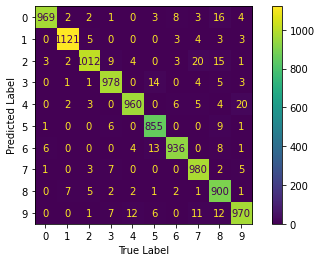

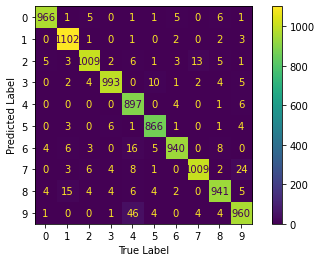

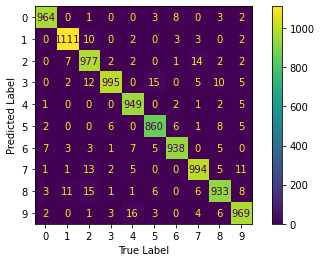

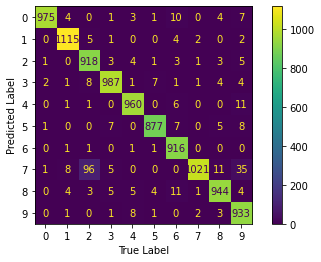

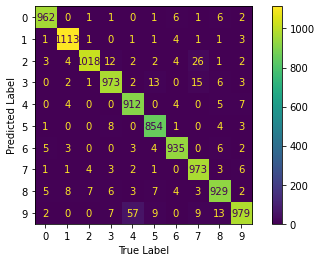

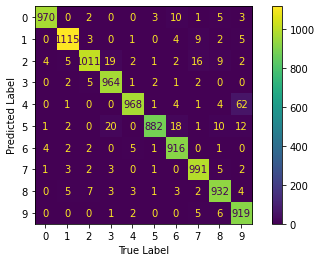

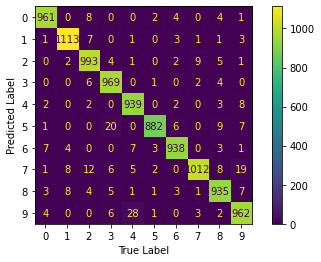

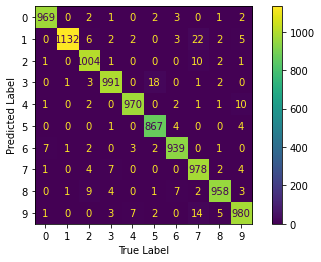

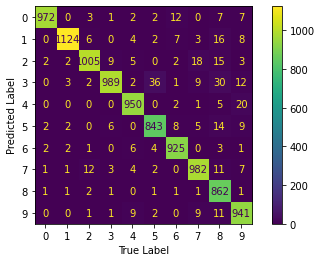

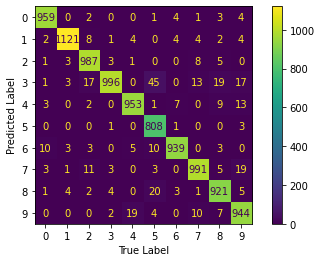

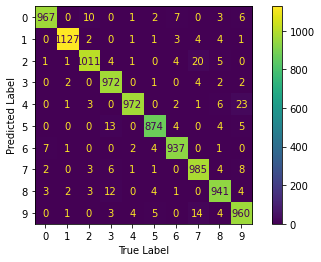

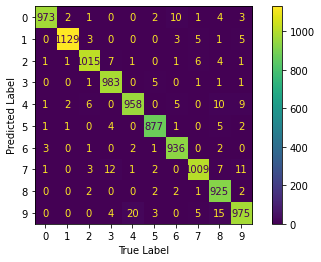

In [30]:
wandb.agent(sweep_id, function=training, count = 12)

<img width="800" src="https://drive.google.com/uc?export=view&id=1zi4EZQdcDtUqp_bA8qaiE6etd-N0NJPP"/>